In [1]:
using DrWatson
@quickactivate "haram"

In [2]:
using main
using Plots, Random, Distributions, ProgressMeter
using Flux, Turing

gr()
default(fmt=:png, levels=7, lw=0.5, msw=0.5, la=0.5)
ProgressMeter.ijulia_behavior(:clear);

In [3]:
function plot_colorbar(cls)
    scatter([0, 0], [0, 1],
        zcolor=[0, 1], clims=(0, 1), xlims=(1, 1.1), c=cls,
        label="", colorbar_title="", framestyle=:none
    )
end

function nn_plot(theta; res=25, c=:viridis)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> reconstruct(theta)([x, y])[1],
        c=c
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ts),
        m=map(x -> x == 1 ? :square : :circle, ts),
        group=ts,
        legend=:bottomright
    )
end

function nn_plot_mean(thetas; c=:viridis, res=25)
    x_range = collect(range(-6; stop=6, length=res))
    contourf(
        x_range, x_range,
        (x, y) -> mean([reconstruct(theta)([x, y])[1] for theta in eachrow(thetas)]), 
        c=c
    )
    scatter!(
        Tuple.(eachrow(xs)),
        c=map(x -> x == 1 ? :firebrick1 : :dodgerblue1, ts),
        m=map(x -> x == 1 ? :square : :circle, ts),
        group=ts,
        legend=:bottomright
    )
end

nn_plot_mean (generic function with 1 method)

In [4]:
Random.seed!(2022)
s = 1.25
μ = [[1.0 1.0], [-1.0 -1.0], [1.0 -1.0], [-1.0 1.0],] .* 2
x0 = [s .* randn(30, 2) .+ μ[1]; s .* randn(100, 2) .+ μ[2]]
x1 = [s .* randn(10, 2) .+ μ[3]; s .* randn(80, 2) .+ μ[4]]
xs = [x0; x1]
ts = [zeros(size(x0, 1)); ones(size(x1, 1))] .|> Int;

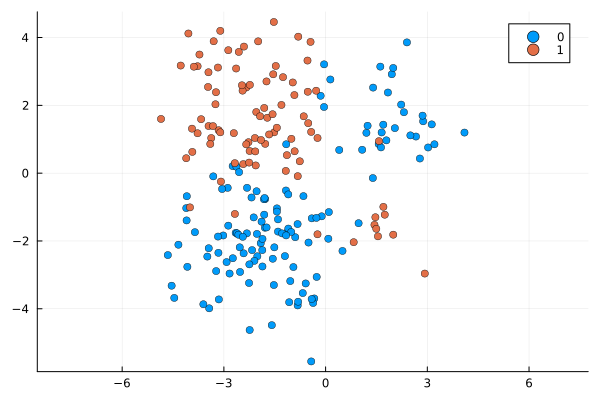

In [5]:
scatter(Tuple.(eachrow(xs)), group=ts, ratio=1)

In [6]:
nn = Chain(
    Dense(2, 3, tanh),
    Dense(3, 2, tanh),
    Dense(2, 1, sigmoid)
)

parameters_initial, reconstruct = Flux.destructure(nn)
sigma = sqrt(1.0 / 0.09)

@model function bayes_nn(xs, ts, nparameters, reconstruct)
    parameters ~ MvNormal(zeros(nparameters), sigma .* ones(nparameters))
    nn = reconstruct(parameters)
    preds = nn(xs)
    for i in eachindex(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

U(x) = -logjoint(bayes_nn(xs', ts, length(parameters_initial), reconstruct), (; parameters=x))
f(x) = exp(U(x))
model = Model(ξ=mod, d=20, f=f, U=U);

In [7]:
Random.seed!(2022)
@time s1, a1 = mcmc(
    HaRAM(ϵ=0.05, L=4, γ=0.32),
    model; n=5e3, n_burn=1e3
)
x_haram = s1[a1, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47
  HaRAM:  0.6558906848858523


Acceptance Ratio = 0.6547
108.041631 seconds (223.29 M allocations: 58.303 GiB, 8.07% gc time, 38.91% compilation time: 0% of which was recompilation)


In [8]:
Random.seed!(2022)
@time s2, a2 = mcmc(
    main.HMC(ϵ=0.05, L=4),
    model; n=5e3, n_burn=1e3
)
x_hmc = s2[a2, :];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
  main.HMC:  0.8138643559406765


Acceptance Ratio = 0.8021
 35.063137 seconds (92.05 M allocations: 28.115 GiB, 10.94% gc time, 0.91% compilation time)


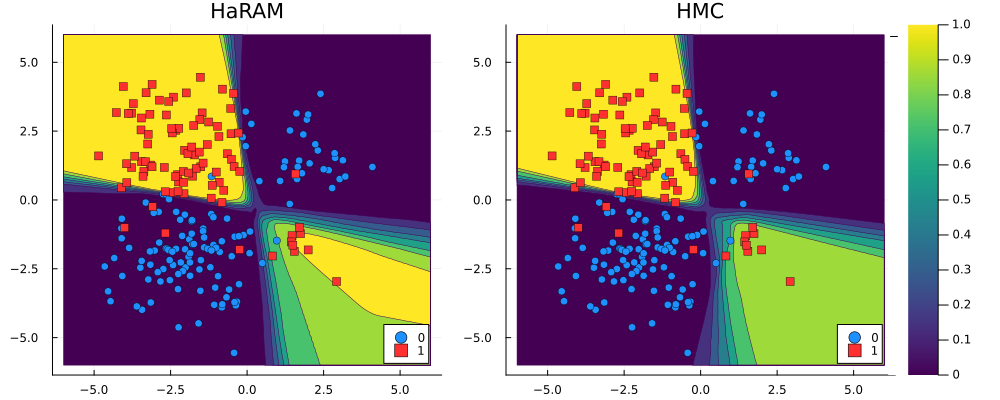

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [9]:
st, res = 50, 200
cls = palette(:viridis, rev=false)

plot(
    plot(
        nn_plot_mean(x_haram[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HaRAM",
    ),
    plot(
        nn_plot_mean(x_hmc[1:st:end, :], res=res, c=cls),
        colorbar=false, title="HMC",
    ),
    plot_colorbar(cls),
    layout=(@layout [grid(1, 2) a{0.035w}]),
    link=:all,
    size=(1000, 400)
)